# Pre-processing and Modeling

In this notebook, my objective is to consolidate some features to make the predictor matrix more rank efficient and then analyze various linear regression models to determine the most accurate prediction algorithm utilizing linear regression. 

My work flow is as follows:
* Create new features to make predictors more rank efficient
* Perform  the baseline model (the mean sale price is the result of the predictors)
* Perform  linear regression with features filtered by their VIF and Recursive Feature Elimination 
* Perform  linear regression with an overfit model to all of my features
* Perform  linear regression with a lasso (L1) regularized linear regression
* Perform linear regression with a Ridge (L2) regularized linear regression
* Perform standard linear regression with features identified as significant by lasso regularization
* Identify production algorithm
    * Defend choice of production algorithm
    * Explanation of model
    * Performance successes and downfalls
* Kaggle Submission Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.formula.api import ols

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

In [2]:
# Reading in training dataset
train = pd.read_csv('../datasets/output/train_clean.csv')

In [3]:
# Feature engineering to make matrix more efficient

train['cond*qual'] = train['overall_cond'] * train['overall_qual']

#Total 1st and 2nd floor square feet
train['total_1st_2nd_floor_sf'] = train['1st_flr_sf'] + train['2nd_flr_sf']
train.drop(columns=['1st_flr_sf', '2nd_flr_sf'], inplace=True)

#Total number of bathrooms (not in basement)
train['total_bath'] = train['full_bath'] + (train['half_bath'] * 0.5)
train.drop(columns=['full_bath', 'half_bath'], inplace=True)

#Total number of basement bathrooms
bsmt_half = train['bsmt_half_bath'] * 0.5
train['bsmt_total_bath'] = train['bsmt_full_bath'] + (bsmt_half)
train.drop(columns=['bsmt_full_bath', 'bsmt_half_bath'], inplace=True)

In [4]:
# Removing variables that are problematic
var_removal = ['pid', 'saleprice', 'log_saleprice', 'ms_subclass']

In [5]:
# Setting my X variables to numeric columns

#x_test_vars = train._get_numeric_data().columns.drop(var_removal).to_list()
x_vars = train._get_numeric_data().columns.drop(var_removal).to_list()

In [6]:
# Taken from my lab 3.01 metrics function

def create_metrics(y_test, y_prediction):
    '''Returns 4 important metrics for assessing model performance: 
    Mean Squared Error(MSE),Root-Mean-Squared-Error(RMSE), Mean-Absolute-Error(MAE),
    R² or Coefficient of Determination, and Max error
    ---
    Parameters
    
    y_test: Sale price in y test sample
    y_prediction: Sale price predicted by my model
    '''
    
    #model = model_type
    #model.fit(X,y)
    y = y_test
    y_hat = y_prediction
    
    mse = metrics.mean_squared_error(y, y_hat)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(y, y_hat)
    r2 = metrics.r2_score(y, y_hat)
    #sse = ((y - y_hat) ** 2).sum()
    max_error = metrics.max_error(y, y_hat)
    
    print( f'The root mean squared error is {rmse}', 
    f'The mean absolute error is {mae}',
    f'The r2 is {r2}',  
    f'The max error is {max_error}', sep = '\n')


## Production Model Tuning

I will progressively refine models utilizing feature selection techniques that optimize the model's overall performance. 

## Baseline

It is critical to compare potential production models against the predictive accuracy of a baseline model. For linear regression, the baseline model is created by fitting all of our predictors against the mean y value (result of predictors). In this case, the result variable is the sale price, so our baseline model measures how well we can predict the mean of all the sale prices. 

In [7]:
# Creating baseline X and y set
X_1 = train[x_vars]
y_1 = train['saleprice']

In [8]:
# Split train testing baseline data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=73)

In [9]:
# Instantiating DummyRegressor, which generates predictions based on mean of sale price

dr = DummyRegressor()

In [10]:
# Fitting DummyRegressor to training data 

dr.fit(X_train_1, y_train_1)
prediction_1 = dr.predict(X_test_1)
residuals_1 = y_test_1 - prediction_1

In [11]:
# Creating metrics for baseline model

create_metrics(y_test_1, prediction_1)

The root mean squared error is 77569.28742347666
The mean absolute error is 55984.58167451846
The r2 is -0.01090799323090108
The max error is 404536.16931540344


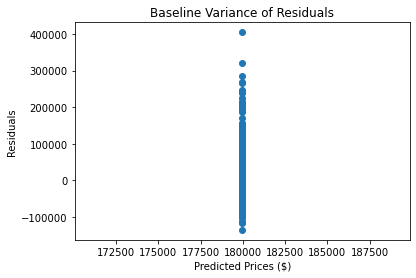

In [12]:
plt.scatter(x=prediction_1, y=residuals_1)
plt.xlabel('Predicted Prices ($)')
plt.ylabel('Residuals')
plt.title('Baseline Variance of Residuals');

Highly biased variances tells me that this model will not predict home price. 

<Figure size 648x648 with 0 Axes>

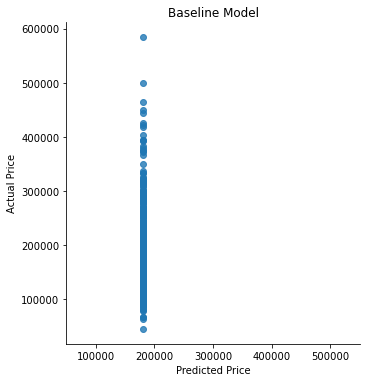

In [13]:
baseline_model = pd.DataFrame({'Predicted Price': prediction_1, 
                                 'Actual Price': y_test_1})

plt.figure(figsize=(9,9));
sns.lmplot(data=baseline_model, x='Predicted Price', y= 'Actual Price')
plt.xlim(50_000, 550_000)
plt.title('Baseline Model');

There is an undefined slope due to the lack of a relationship between the predicted price and the actual price in my baseline model.

## Linear Regression with Feature Selection

I utilize this model to measure the effect of multi-collinearity and recursive feature selection on the predictive ability of a standard linear regression model. I throw out all features with a variance inflation factor greater than 10 and then utilize the sklearn's recursive feature eliminator to automatically features most predictive of sale price. My model with the largest amount of features that have VIF less than 10 has an R2 value of 0.879. While not as predictive as subsequent models, the process of eliminating multicollinear features would make the individual linear regression slope coefficients for each of these predictors more interpretable than other models that allow these features to stay in them.

The recursive feature eliminator would be very effective for determining a number of features that are most important for determining the sale price.  

In [14]:
# Creating variance inflation factor dataframe utilizing features in my X variable 

vif = pd.DataFrame()
vif['vif_factor'] = [variance_inflation_factor(train[x_vars].values, i) 
                     for i in range(train[x_vars].shape[1])]
vif['features'] = x_vars 

/Users/johnnybex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [15]:
# Creating list of columns that have VIF less than 10

refined_columns = (vif[vif['vif_factor'] <= 10])['features'].to_list()

In [16]:
# Instantiating Linear regresion model 
lm = LinearRegression()


In [17]:
# Utilizing recursive feature eliminator to determine the impact the number of 
# features has on the overlal predictive ability. 

rfe = RFE(lm, n_features_to_select=57)
rfe.fit(train[refined_columns], train['saleprice'])
rfe_df = pd.DataFrame({'RFE Coef_': rfe.ranking_, 'Feature': refined_columns})

In [18]:
# Creating dataframe of most important features 

rfe_columns = rfe_df[rfe_df['RFE Coef_'] == 1]['Feature'].to_list()

In [19]:
# Creating predictors and result variable

X_2 = train[rfe_columns]
y_2 = train['saleprice']

In [20]:
# Train test splitting 

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=73)

In [21]:
# Power transformation of Sale Price that was justified in Cleaning and EDA Notebook

y_train_log_2 = y_train_2.map(np.log)
y_test_log_2 = y_test_2.map(np.log)

In [22]:
# Instantiating linear regression and fitting to predictors and sale price 

lr = LinearRegression()
lr.fit(X_train_2, y_train_log_2)

LinearRegression()

In [23]:
# Calculating the predicted sale price and residuals from linear regression

prediction_2 = lr.predict(X_test_2)
residuals_2 = y_test_log_2 - prediction_2
pred_prices_2 = np.exp(prediction_2)

In [24]:
# Creating metrics for model comparison 

create_metrics(y_test_2, pred_prices_2)

The root mean squared error is 27627.70008484095
The mean absolute error is 19699.78633836649
The r2 is 0.8717605955700357
The max error is 159129.31268251993


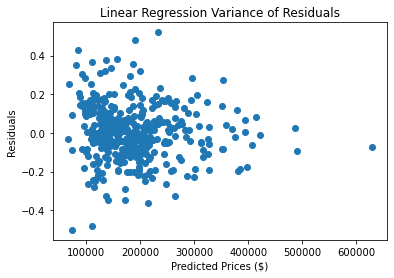

In [25]:
plt.scatter(x=pred_prices_2, y=residuals_2)
plt.xlabel('Predicted Prices ($)')
plt.ylabel('Residuals')
plt.title('Linear Regression Variance of Residuals');

While the variance is not perfectly homoscedastic, the plot above shows a fairly equal variance in residuals that proves the efficacy of my model. 

<Figure size 648x648 with 0 Axes>

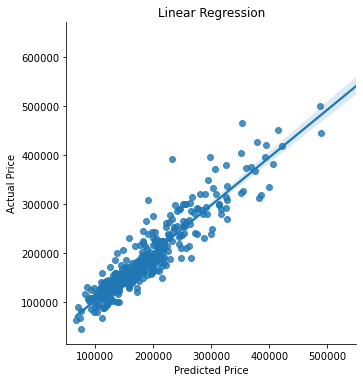

In [26]:
linear_regression = pd.DataFrame({'Predicted Price': pred_prices_2, 
                                 'Actual Price': y_test_2})

plt.figure(figsize=(9,9));
sns.lmplot(data=linear_regression, x='Predicted Price', y= 'Actual Price')
plt.xlim(50_000, 550_000)
plt.title('Linear Regression');

|Number of Features|R2|
|---|---|
|10|0.7938|
|20|0.8507|
|30|0.8527|
|40|0.8547|
|50|0.8710|
|57|0.8793|


As the number of features increases, my model becomes more accurate. I need to introduce more features into my model while safely accounting for the effects of multicollinearity. 
To do so, I must evaluate how well an overly-fit linear regression performs with no feature reduction. 

## Overfit Linear Regression

My overfit linear regression model utilizes all 93 numerical features that are present from my pre-processing and data cleaning stage. This model has a very high R2, but the prevalence of multicollinearity throughout the model would make the interpretation of each individual slope in my linear regression impossible. This model would also not generalize well to any other home appraisal checklist due to the overfit nature. 

In [27]:
# Creating predictors and predictor result variable 

X_3 = train[x_vars]
y_3 = train['saleprice']

In [28]:
# Test train splitting preictors and predictor results

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=73)

In [29]:
# Power transformation of Sale Price 

y_train_log_3 = y_train_3.map(np.log)
y_test_log_3 = y_test_3.map(np.log)

In [30]:
# Instantiating Linear Regression and fitting to my training data
lr_2 = LinearRegression()
lr_2.fit(X_train_3, y_train_log_3)

LinearRegression()

In [31]:
prediction_3 = lr_2.predict(X_test_3)

In [32]:
# Pedictions and residuals from this linear regression model 

residuals_3 = y_test_log_3 - prediction_3
pred_prices_3 = np.exp(prediction_3)

In [33]:
# Linear regression metrics 

create_metrics(y_test_3, pred_prices_3)

The root mean squared error is 20146.0066735281
The mean absolute error is 13684.33487440474
The r2 is 0.9318116826524866
The max error is 139021.89910840036


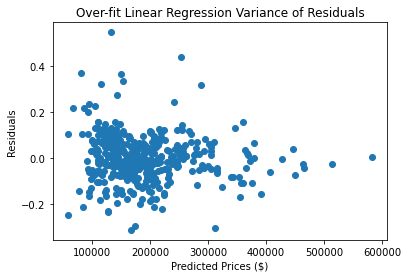

In [34]:
plt.scatter(x=pred_prices_3, y=residuals_3)
plt.xlabel('Predicted Prices ($)')
plt.ylabel('Residuals')
plt.title('Over-fit Linear Regression Variance of Residuals');

The variance in this model is even smaller than the past, however there is still a noticeable heterscedastic pattern in the residuals. As the predicted proce gets smaller, I have a larger variance in residuals.

<Figure size 648x648 with 0 Axes>

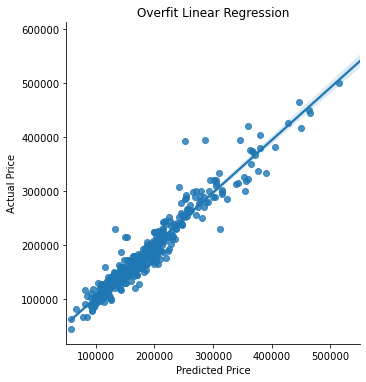

In [35]:
overfit_model = pd.DataFrame({'Predicted Price': pred_prices_3, 
                                 'Actual Price': y_test_3})

plt.figure(figsize=(9,9));
sns.lmplot(data=overfit_model, x='Predicted Price', y= 'Actual Price')
plt.xlim(50_000, 550_000)
plt.title('Overfit Linear Regression');

The linear regression is showing great predictive ability with a root mean squared error at 20146.0066735281 dollars compared to 27627.70008484095 and 77569.28742347666 dollars for my linear regression and baseline models respectively. The R2 is also significantly improved for the test set, indicating that the predictive ability for this model is quite high. However, it will be computationally expensive for larger datasets due to the number of features it takes into consideration and will not generalize well to larger datasets. 

## Linear Regression with Lasso (L1) Regularization

Lasso regularization simplifies our model, reducing variance bias, through the L1 penalty coefficient. This coefficient will take the slop of some features down to zero, thus creating a more sparse set of features to work with. Doing so will improve computational efficiency and reduce the variance error. 

To perform lasso regularization, we need to standard scale the predictors to their (transform predictor values into their z-score value). By doing so, we can accurately compare the different features, which may have variable units otherwise. 

In [36]:
# Standard Sclaing the full predictor training abnd test sets
ssc = StandardScaler()

# Utilizing previous test train split because I am using all of the features
# In my lasso regression

Z_train = ssc.fit_transform(X_train_3)
Z_test = ssc.transform(X_test_3)

In [37]:
# creating list of potential alphas for lasso regularization
lasso_alphas = np.logspace(0,3,100)

# utilizing LassoCV which has built-in 5 fold cross-validation for determing
# the best alpha values for each feature.
lasso = LassoCV(alphas=lasso_alphas, cv=5, max_iter=50000)

#Fitting lasso model 
lasso.fit(Z_train, y_train_3);

In [38]:
# Creating DataFrame with each lasso coefficient per feature
lasso_coef = pd.DataFrame({'lasso.coef_':lasso.coef_, 'features': x_vars})

In [39]:
# Creating list of lasso features with coefficients > 0, i.e. features
# regularization deemed important. 

lasso_feats = lasso_coef[lasso_coef['lasso.coef_'] != 0]['features'].to_list()

In [40]:
# Predicted values from lasso regularization linear regression 
lasso_predicts = lasso.predict(Z_test)

In [41]:
# Metrics for comparing models
create_metrics(y_test_3, lasso_predicts)

The root mean squared error is 23893.297755214237
The mean absolute error is 16208.792073932631
The r2 is 0.9040855110283663
The max error is 151359.89572789194


In [42]:
# Calculating residuals 

lasso_residuals = y_test_3 - lasso_predicts

Text(0.5, 1.0, 'Equal Variance of Residuals')

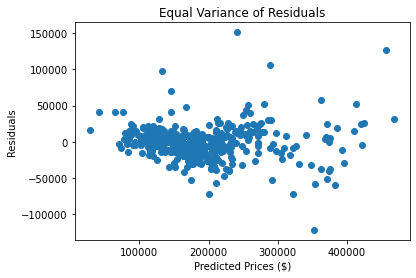

In [43]:
plt.scatter(x=lasso_predicts, y=lasso_residuals)
plt.xlabel('Predicted Prices ($)')
plt.ylabel('Residuals')
plt.title('Equal Variance of Residuals')

The variance in residual values is more homoscedastic than the previous linear regressions, however there is a larger range of residuals. This range in residuals is responsible for the lower R2 than the overfit linear regression.

<Figure size 648x648 with 0 Axes>

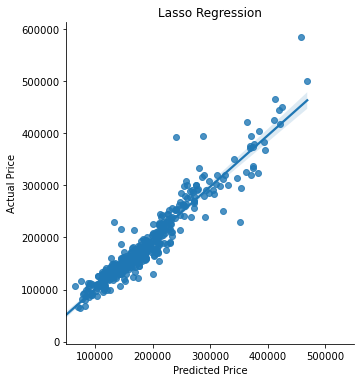

In [44]:
lasso_model = pd.DataFrame({'Predicted Price': lasso_predicts, 
                                 'Actual Price': y_test_3})

plt.figure(figsize=(9,9));
sns.lmplot(data=lasso_model, x='Predicted Price', y= 'Actual Price')
plt.xlim(50_000, 550_000)
plt.title('Lasso Regression');

The root mean squared error is slightly worse than my overfit linear regression at $23893.297755214237. Perhaps an L2 penalty term will improve this error. 

## Linear Regression with Ridge (L2) Regularization 

Ridge regression utilizes L2 regularization to adjust feature slope coefficient values. However, it does not reduce unimportant features to 0 like lasso, and thus results in a more dense predictor matrix with slightly less interpretability than the lasso regularization linear regression. However, it also results in less bias. 

In [45]:
# Cross validating the ridge alpha (L2) penalty facot
ridge_alpha = np.logspace(0, 70, 100)
ridge_cv = RidgeCV(alphas=ridge_alpha, scoring='r2', cv=5)

# Fitting the resulting Ridge Regularization model 
ridge_cv.fit(Z_train, y_train_3);


In [46]:
# Ridge regression price prediction
ridge_predicts = ridge_cv.predict(Z_test)

In [47]:
# Ridge residuals
ridge_residuals = y_test_3 - ridge_predicts

In [48]:
create_metrics(y_test_3, ridge_predicts)

The root mean squared error is 23755.21636416522
The mean absolute error is 16230.883061723143
The r2 is 0.905190903601462
The max error is 151035.67764525345


Text(0.5, 1.0, 'Equal Variance of Residuals')

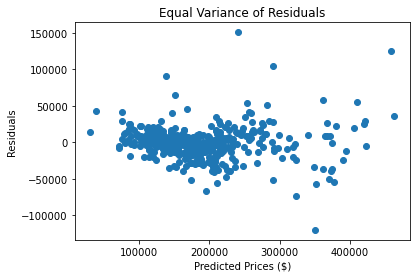

In [49]:
plt.scatter(x=ridge_predicts, y=ridge_residuals)
plt.xlabel('Predicted Prices ($)')
plt.ylabel('Residuals')
plt.title('Equal Variance of Residuals')

In [50]:
ridge_regression = pd.DataFrame({'Predicted Price': ridge_predicts, 
                                 'Actual Price': y_test_3})

<Figure size 648x648 with 0 Axes>

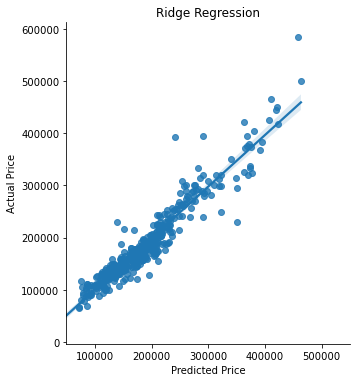

In [51]:
plt.figure(figsize=(9,9));
sns.lmplot(data=ridge_regression, x='Predicted Price', y= 'Actual Price')
plt.xlim(50_000, 550_000)
plt.title('Ridge Regression');
#plt.xticks(labels=['50k', '100k', '150k', '200k', '250k', '300k', '350k', 
                   #'400k', '450k', '500k', '550k'])

This model has a slight improvement over the lasso regression in both root means squared error and R2 value. The linear regression model seems to be the best predictor, can we combine the benefits of lasso regression with the linear regression to optimize for both performance and accuracy? 

## Linear Regression with Lasso Features

My final model utilizes the list of features deemed important by the lasso regularization and inputs those features as my predictors for a standardized linear regression. This model thus combines the feature importance hierarchy from the lasso regression with the accuracy of the linear regression. 

In [52]:
# New training data
X_4 = train[lasso_feats]
y_4 = train['saleprice']

In [53]:
# Train test splits
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.2, random_state=73)

In [54]:
# Power transformation of Sale Price
y_train_log_4 = y_train_4.map(np.log)
y_test_log_4 = y_test_4.map(np.log)

In [55]:
# Fitting 3rd linear regression model with training data
lr_3 = LinearRegression()
lr_3.fit(X_train_4, y_train_log_4)

LinearRegression()

In [56]:
# Linear regression prediction and 
prediction_4 = lr_3.predict(X_test_4)

In [57]:
# Residual calculations
residuals_4 = y_test_log_4 - prediction_4
pred_prices_4 = np.exp(prediction_4)

In [58]:
create_metrics(y_test_4, pred_prices_4)

The root mean squared error is 20351.755103076543
The mean absolute error is 13796.534802948207
The r2 is 0.9304117743891719
The max error is 135556.83459956126


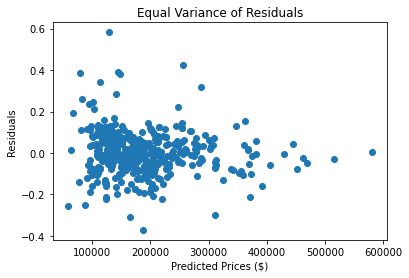

In [59]:
plt.scatter(x=pred_prices_4, y=residuals_4)
plt.xlabel('Predicted Prices ($)')
plt.ylabel('Residuals')
plt.title('Equal Variance of Residuals');

In [60]:
production_model = pd.DataFrame({'Predicted Price': pred_prices_4, 
                                 'Actual Price': y_test_4})

<Figure size 648x648 with 0 Axes>

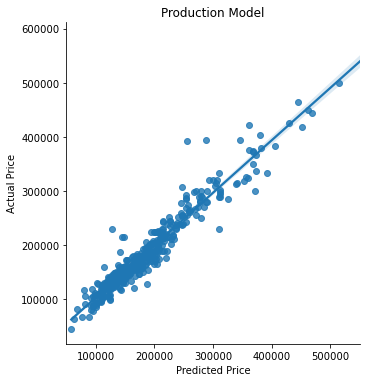

In [61]:
plt.figure(figsize=(9,9));
sns.lmplot(data=production_model, x='Predicted Price', y= 'Actual Price')
plt.xlim(50_000, 550_000)
plt.title('Production Model');

This model is only slightly worse than the overfit regression while having a 157% jump in performance (22ms vs 14ms for model predictions). Thus this model would be my recommended model to present to my clients. 

## Production Algorithm

For my final production algorithm, I would choose the standardized linear regression model with lasso features. This algorithm has similar R2 and Root Mean Squared Error (RMSE) values to the overfit linear regression (which has the best values for both), with the addeed benefit of being slightly more generalizable due to the feature reduction. 

### Why this Algorithm? 

While the overfit standard linear regression model had the best R2 and Root Mean Squared Error (RMSE) values, they were only marginally better than the linear regression model with lasso features. The added benefit of choosing linear regression with lasso features over the overfit linear regression model is two-fold:

* Feature reduction improves the variance error, thus making the model more generalizable to a wider array of Ames Housing datasets. 
* Feature reduction improves the performance of the model, allowing the predictions to be calculated more efficiently for a larger Ames Housing dataset. 

Therefore, for an appraiser trying to model housing prices on a large number of Ames houses, the linear regression with lasso features is the ideal production model. 

In [62]:
production_model = pd.DataFrame({'Production Model Slope':lr_3.coef_, 
                                                'Features': lasso_feats})

interpretation = (np.exp(production_model['Production Model Slope']) - 1) * 100

production_model['Interpretation (% Sale Price Increase)'] = interpretation
production_model

,Production Model Slope,Features,Interpretation (% Sale Price Increase)
0,0.000302,lot_frontage,0.030173
1,0.000003,lot_area,0.000316
2,0.012866,overall_qual,1.294886
3,0.001791,year_built,0.179308
4,0.000760,year_remod/add,0.076057
5,0.000013,mas_vnr_area,0.001350
6,0.000068,bsmtfin_sf_1,0.006816
7,0.000030,bsmtfin_sf_2,0.002955
8,0.000106,total_bsmt_sf,0.010639
9,0.000091,gr_liv_area,0.009111


In [63]:
production_model.sort_values('Interpretation (% Sale Price Increase)', ascending=False)[:15]

,Production Model Slope,Features,Interpretation (% Sale Price Increase)
25,0.193895,ms_zoning_250k,21.396888
24,0.148376,ms_zoning_200k,15.994887
23,0.080606,ms_zoning_150k,8.394384
66,0.070528,paved_drive_200k,7.307469
51,0.067487,bsmt_qual_300k,6.981680
62,0.056725,kitchen_qual_300k,5.836437
35,0.054359,bldg_type_200k,5.586362
53,0.053196,bsmt_exposure_300k,5.463633
34,0.048847,condition_1_200k,5.005968
47,0.047421,exter_cond_200k,4.856380


The interpretation column tells us that a one unit increase in the feature results in the corresponding percent increase in Sale Price, holding all other features constant. For example, a one square foot increase in lot_frontage results in a .03% increase in the home's sale price, holding all other features constant. 

For the categorical columns, the % increase is telling us that if categorical value is attributed to the home it leads to that % increase in the home's sale price. For example, having a home zoned in an area with a mean value between 200k and 250K leads to a 21.397% increase in the home's sale price. Where you buy a home really matters!

## Kaggle Submission

In [64]:
## Reading in test dataset
test = pd.read_csv('../datasets/test.csv')

In [65]:
# Cleaning the name of the test column headers
for col in test.columns:
    test.rename(columns={col: col.lower().replace(' ','_')}, inplace=True)

In [66]:
# Feature engineering to make matrix more efficient

test['cond*qual'] = test['overall_cond'] * test['overall_qual']

#Total 1st and 2nd floor square feet
test['total_1st_2nd_floor_sf'] = test['1st_flr_sf'] + test['2nd_flr_sf']
test.drop(columns=['1st_flr_sf', '2nd_flr_sf'], inplace=True)

#Total number of bathrooms (not in basement)
test['total_bath'] = test['full_bath'] + (test['half_bath'] * 0.5)
test.drop(columns=['full_bath', 'half_bath'], inplace=True)

#Total number of basement bathrooms
bsmt_half = test['bsmt_half_bath'] * 0.5
test['bsmt_total_bath'] = test['bsmt_full_bath'] + (bsmt_half)
test.drop(columns=['bsmt_full_bath', 'bsmt_half_bath'], inplace=True)

In [67]:
# droppin unnecessary numerical features or categorical features that are numerical
drop_cols = ['ms_subclass', 'pid']
numerical_columns = test._get_numeric_data().columns.drop(drop_cols)

In [68]:
# Filling null vallues with with values used in training data
test['garage_yr_blt'] = test['garage_yr_blt'].fillna(test['garage_yr_blt'].median())
test[numerical_columns] = test[numerical_columns].fillna(0)

In [69]:
# Importing categorical features
cat_features = pd.read_csv('../datasets/output/categorical_features.csv')

In [70]:
# Creating list of categorical features
cat_column_list = cat_features['Categorical_Features'].to_list()

In [71]:
# One-hot encoding test dataframe with same dummy columns as the training dataset
def one_hot_encode_test(column_list):
    
    '''One hot encodes categorical features into 5 possible bins: one of the 
    150k, 200k, 250k, 300k sale bins or the dropped bin which includes values
    with not enough features to be included in one of the sale price bins. 
    ---
    Parameter:
    column_list: list of categorical columns to be one-hot encoded.'''
    
    # List of dummy columns created 
    dummy_columns = []
    columns_dummied = []
    
    for col in column_list:
    # Creates series of values in column with their sale price
        col_groupby = train.groupby(col)['saleprice']
        col_count_mean = col_groupby.agg(['count', 'mean'])
        
        
        # Ensures that sparse values are not included 
        col_counts = col_count_mean['count'] > 100
        if len(col_count_mean[col_counts]) < 2:
            continue
            
        
        # Sale price binning for each feature 
        # The price associated with the first 3 bins denotes the price to 
        # which the bin goes up to, wheras the last bin represents the values 
        # that round to 300k
        col_price_150k = col_count_mean['mean'] <= 150_000
        
        col_price_200k = ((col_count_mean['mean'] > 150_000) & 
                                (col_count_mean['mean'] <= 200_000))
        
        col_price_250k = ((col_count_mean['mean'] > 200_000) & 
                                (col_count_mean['mean'] <= 250_000))
        
        col_price_300k = col_count_mean['mean'] > 250_000
        
        
        # List of values in each feature that meet sale price conditions and count values
        col_150k_values = col_count_mean[(col_counts) & 
                                         (col_price_150k)].index.to_list()
        
        col_200k_values = col_count_mean[(col_counts) & 
                                         (col_price_200k)].index.to_list()
        
        col_250k_values = col_count_mean[(col_counts) & 
                                         (col_price_250k)].index.to_list()
        
        col_300k_values = col_count_mean[(col_counts) & 
                                         (col_price_300k)].index.to_list()
        
        
        
        # Masking train for dummy column creation
        col_150k_mask = test[col].isin(col_150k_values)
        col_200k_mask = test[col].isin(col_200k_values)
        col_250k_mask = test[col].isin(col_250k_values)
        col_300k_mask = test[col].isin(col_300k_values)
        
        # Getting base column name for dummy column creation 
        column_name = f'{col}'
        columns_dummied.append(column_name)
        
        columns_created = []
        
        # Creating dummy columns
        if sum(col_150k_mask) > 0:
            test[column_name + '_150k'] = col_150k_mask.astype(int)
            columns_created.append(column_name + '_150k')
        if sum(col_200k_mask) > 0:
            test[(column_name + '_200k')] = col_200k_mask.astype(int)
            columns_created.append(column_name + '_200k')
        if sum(col_250k_mask) > 0:
            test[(column_name + '_250k')] = col_250k_mask.astype(int)
            columns_created.append(column_name + '_250k')
        if sum(col_300k_mask) > 0:
            test[(column_name + '_300k')] = col_300k_mask.astype(int)
            columns_created.append(column_name + '_300k')
            
        
        # Filling null values with 0 
        train.loc[:, columns_created] = train[columns_created].fillna(0)
        
        # Adding dummy columns to dummy_column list
        dummy_columns += columns_created
        
    return (columns_dummied, dummy_columns)

categorical_cols = one_hot_encode_test(cat_column_list)

In [72]:
# Creating test predictors
X_test = test[lasso_feats]

In [73]:
# Predicting the result of my linear regression
prediction_test = lr_3.predict(X_test)

In [74]:
# Test Sale Prices determined via linear regression
test_prices = np.exp(prediction_test)

In [75]:
# Creeating dataframe to submit data
test_saleprice = pd.DataFrame(test['id'])
test_saleprice['SalePrice'] = test_prices

In [76]:
test_saleprice

,id,SalePrice
0,2658,131565.636815
1,2718,153855.396341
2,2414,215515.049019
3,1989,100493.947898
4,625,166074.257258
5,333,101983.566205
6,1327,103781.691703
7,858,146548.865115
8,95,184291.193153
9,1568,166282.320964


In [77]:
test_saleprice.to_csv('../datasets/output/kaggle_submission.csv', index=False)